Install the correct version of the required packages (in case you haven't done it yet)

In [ ]:
%pip install -r '../requirements.txt'

### Import libraries

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import yaml
import joblib
from tqdm import tqdm
# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import roc_auc_score, classification_report, f1_score,accuracy_score, recall_score, precision_score
from collections import Counter
import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("shap").setLevel(logging.ERROR)

### Hyperparameter counter

In [3]:
def hyperparameter_counter(counter):
    """Function to determine the best hyperparameter after running gridsearch 100 times."""
    # Extract items with more than 80 counts
    high_count_element = [item for item in counter.keys() if counter[item] > 80]

    if high_count_element:
        return high_count_element[0]
    else:
        # If there are no items with more than 80 counts, calculate the mean of the elements
        total_counts = np.sum([count for item,count in counter.items()])
        mean_value = np.sum(item * count for item, count in counter.items()) / total_counts
        return mean_value

## Mortality 6 weeks after prediction

### Read dataset and define preprocessing steps

In [4]:
df = pd.read_csv("../data/dataset_for_training.csv", header=0)
y = df[["y"]]
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)
X = df.drop(["y"], axis=1)
cats = list(X.select_dtypes(include=["object"]))
conts = list(X.select_dtypes(include=["float", "int"]))
scaler = RobustScaler()
imputer = SimpleImputer(strategy="median")
scalesteps = [("cont_imputer", imputer), ("continuous", scaler)]
scale_pipe = Pipeline(steps=scalesteps)
to_scale_idx = [X.columns.get_loc(cont) for cont in conts]
to_encode_idx = [X.columns.get_loc(cat) for cat in cats]
cat_pipe = Pipeline(
    steps=[
        (
            "categorical",
            OneHotEncoder(handle_unknown="ignore", drop="if_binary"),
        )
    ]
)

preprocess = ColumnTransformer(
            transformers=[
                ("scal", scale_pipe, to_scale_idx),
                ("cat", cat_pipe, to_encode_idx),
            ],
            remainder="passthrough",
        )

X_preprocessed = preprocess.fit_transform(X)
cols = preprocess.get_feature_names_out()
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=cols)
cats = [col for col in cols if col.startswith('cat')]
cats_idx = [X_preprocessed_df.columns.get_loc(cat) for cat in cats]
sampler = SMOTENC(random_state=42,categorical_features=cats_idx)

/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Logistic regression

### Gridsearch

In [5]:
file = "../parameters/gridsearch.yaml"
dict = yaml.safe_load(open(file, "rb"))
param_grid = dict["lor_param"]

M6W_lor_unc_allfeat_pipeline = Pipeline(
            steps=[
                ("preprocess", preprocess),
                ("sampler", sampler),
                ("model", LogisticRegression()),
            ]
        )
C = list()
for i in tqdm(range(100)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=i, stratify=y)
    grid = GridSearchCV(
        M6W_lor_unc_allfeat_pipeline, param_grid, scoring="roc_auc", cv=5, verbose=1, n_jobs=-1
    )
    grid.fit(X_train, y_train)
    C.append(grid.best_params_['model__C'])


c_results = Counter(C)
print(c_results)
M6W_allfeat_lor_C = np.round(hyperparameter_counter(c_results),2)
print(f"Best C: {M6W_allfeat_lor_C}")

M6W_allfeat_lor_best_parameters = {"Best C": float(M6W_allfeat_lor_C)}
print(M6W_allfeat_lor_best_parameters)
with open("../parameters/M_6weeks/LOR/M_6weeks_LOR_allfeatures_best_parameters.yaml", "w") as outfile:
    yaml.dump(M6W_allfeat_lor_best_parameters, outfile, default_flow_style=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


  1%|          | 1/100 [00:04<07:29,  4.54s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


  2%|▏         | 2/100 [00:07<06:09,  3.77s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


  3%|▎         | 3/100 [00:11<05:48,  3.59s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


  4%|▍         | 4/100 [00:14<05:29,  3.43s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


  5%|▌         | 5/100 [00:17<05:17,  3.34s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


  6%|▌         | 6/100 [00:20<05:14,  3.34s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


  7%|▋         | 7/100 [00:24<05:05,  3.29s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


  8%|▊         | 8/100 [00:27<05:06,  3.33s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


  9%|▉         | 9/100 [00:30<04:59,  3.29s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 10%|█         | 10/100 [00:33<04:53,  3.26s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 11%|█         | 11/100 [00:36<04:45,  3.21s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 12%|█▏        | 12/100 [00:40<04:43,  3.22s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 13%|█▎        | 13/100 [00:43<04:36,  3.18s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 14%|█▍        | 14/100 [00:46<04:39,  3.25s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 15%|█▌        | 15/100 [00:49<04:37,  3.26s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 16%|█▌        | 16/100 [00:53<04:34,  3.27s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 17%|█▋        | 17/100 [00:56<04:31,  3.27s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 18%|█▊        | 18/100 [00:59<04:25,  3.24s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 19%|█▉        | 19/100 [01:02<04:22,  3.24s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 20%|██        | 20/100 [01:06<04:22,  3.28s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 21%|██        | 21/100 [01:09<04:15,  3.23s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 22%|██▏       | 22/100 [01:12<04:15,  3.28s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 23%|██▎       | 23/100 [01:16<04:15,  3.32s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 24%|██▍       | 24/100 [01:19<04:08,  3.27s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 25%|██▌       | 25/100 [01:22<04:03,  3.25s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 26%|██▌       | 26/100 [01:25<03:59,  3.23s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 27%|██▋       | 27/100 [01:28<03:53,  3.20s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 28%|██▊       | 28/100 [01:32<03:49,  3.19s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 29%|██▉       | 29/100 [01:35<03:44,  3.17s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 30%|███       | 30/100 [01:38<03:40,  3.15s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 31%|███       | 31/100 [01:41<03:41,  3.21s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 32%|███▏      | 32/100 [01:44<03:36,  3.19s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 33%|███▎      | 33/100 [01:48<03:34,  3.20s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 34%|███▍      | 34/100 [01:51<03:31,  3.20s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 35%|███▌      | 35/100 [01:54<03:25,  3.16s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 36%|███▌      | 36/100 [01:57<03:25,  3.21s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 37%|███▋      | 37/100 [02:00<03:23,  3.22s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 38%|███▊      | 38/100 [02:03<03:16,  3.18s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 39%|███▉      | 39/100 [02:07<03:14,  3.19s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 40%|████      | 40/100 [02:10<03:09,  3.16s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 41%|████      | 41/100 [02:13<03:08,  3.19s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 42%|████▏     | 42/100 [02:16<03:06,  3.22s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 43%|████▎     | 43/100 [02:19<03:00,  3.17s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 44%|████▍     | 44/100 [02:23<03:00,  3.22s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 45%|████▌     | 45/100 [02:26<02:56,  3.20s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 46%|████▌     | 46/100 [02:29<02:51,  3.17s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 47%|████▋     | 47/100 [02:32<02:47,  3.16s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 48%|████▊     | 48/100 [02:35<02:42,  3.12s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 49%|████▉     | 49/100 [02:38<02:36,  3.08s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 50%|█████     | 50/100 [02:41<02:35,  3.12s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 51%|█████     | 51/100 [02:44<02:32,  3.11s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 52%|█████▏    | 52/100 [02:48<02:30,  3.14s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 53%|█████▎    | 53/100 [02:51<02:31,  3.22s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 54%|█████▍    | 54/100 [02:54<02:26,  3.19s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 55%|█████▌    | 55/100 [02:57<02:23,  3.19s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 56%|█████▌    | 56/100 [03:00<02:17,  3.13s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 57%|█████▋    | 57/100 [03:04<02:16,  3.16s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 58%|█████▊    | 58/100 [03:07<02:14,  3.19s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 59%|█████▉    | 59/100 [03:10<02:10,  3.19s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 60%|██████    | 60/100 [03:14<02:11,  3.29s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 61%|██████    | 61/100 [03:17<02:08,  3.29s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 62%|██████▏   | 62/100 [03:20<02:05,  3.31s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 63%|██████▎   | 63/100 [03:23<02:02,  3.31s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 64%|██████▍   | 64/100 [03:27<02:00,  3.35s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 65%|██████▌   | 65/100 [03:30<01:54,  3.27s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 66%|██████▌   | 66/100 [03:33<01:49,  3.23s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 67%|██████▋   | 67/100 [03:36<01:44,  3.17s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 68%|██████▊   | 68/100 [03:39<01:39,  3.12s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 69%|██████▉   | 69/100 [03:42<01:37,  3.15s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 70%|███████   | 70/100 [03:46<01:34,  3.13s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 71%|███████   | 71/100 [03:49<01:31,  3.15s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 72%|███████▏  | 72/100 [03:52<01:28,  3.16s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 73%|███████▎  | 73/100 [03:55<01:25,  3.15s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 74%|███████▍  | 74/100 [03:58<01:21,  3.15s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 75%|███████▌  | 75/100 [04:01<01:18,  3.14s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 76%|███████▌  | 76/100 [04:04<01:15,  3.13s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 77%|███████▋  | 77/100 [04:08<01:11,  3.13s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 78%|███████▊  | 78/100 [04:11<01:08,  3.12s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 79%|███████▉  | 79/100 [04:14<01:08,  3.24s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 80%|████████  | 80/100 [04:18<01:08,  3.43s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 81%|████████  | 81/100 [04:21<01:03,  3.37s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 82%|████████▏ | 82/100 [04:24<00:59,  3.32s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 83%|████████▎ | 83/100 [04:28<00:56,  3.31s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 84%|████████▍ | 84/100 [04:31<00:51,  3.25s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 85%|████████▌ | 85/100 [04:34<00:48,  3.20s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 86%|████████▌ | 86/100 [04:37<00:44,  3.20s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 87%|████████▋ | 87/100 [04:40<00:41,  3.16s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 88%|████████▊ | 88/100 [04:43<00:38,  3.17s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 89%|████████▉ | 89/100 [04:47<00:35,  3.18s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 90%|█████████ | 90/100 [04:50<00:32,  3.21s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 91%|█████████ | 91/100 [04:53<00:29,  3.25s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 92%|█████████▏| 92/100 [04:57<00:26,  3.27s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 93%|█████████▎| 93/100 [05:00<00:22,  3.27s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 94%|█████████▍| 94/100 [05:03<00:19,  3.27s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 95%|█████████▌| 95/100 [05:06<00:15,  3.20s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 96%|█████████▌| 96/100 [05:09<00:12,  3.18s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 97%|█████████▋| 97/100 [05:12<00:09,  3.17s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 98%|█████████▊| 98/100 [05:16<00:06,  3.17s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


 99%|█████████▉| 99/100 [05:19<00:03,  3.19s/it]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


100%|██████████| 100/100 [05:22<00:00,  3.22s/it]

Counter({0.01: 85, 0.1: 10, 0.001: 5})
Best C: 0.01
{'Best C': 0.01}


## Random forest classifier

### Gridsearch

In [6]:
file = "../parameters/gridsearch.yaml"
dict = yaml.safe_load(open(file, "rb"))
param_grid = dict["rf_gb_param"]

M6W_rf_unc_allfeat_pipeline = Pipeline(
            steps=[
                ("preprocess", preprocess),
                ("sampler", sampler),
                ("model", RandomForestClassifier(random_state=42)),
            ]
        )
minsamplessplit = list()
n_estims = list()
maxdepth = list()
minsamplesleaf = list()
for i in tqdm(range(100)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=i, stratify=y)
    grid = GridSearchCV(
        M6W_rf_unc_allfeat_pipeline, param_grid, scoring="roc_auc", cv=5, verbose=1, n_jobs=-1
    )
    grid.fit(X_train, y_train)
    minsamplessplit.append(grid.best_params_['model__min_samples_split'])
    n_estims.append(grid.best_params_['model__n_estimators'])
    maxdepth.append(grid.best_params_['model__max_depth'])
    minsamplesleaf.append(grid.best_params_['model__min_samples_leaf'])

minsamplessplit_results = Counter(minsamplessplit)
n_estims_results = Counter(n_estims)
maxdepth_results = Counter(maxdepth)
minsamplesleaf_results = Counter(minsamplesleaf)
print(minsamplessplit_results, n_estims_results, maxdepth_results, minsamplesleaf_results)

M6W_allfeat_rf_minsamplessplit = int(np.round(hyperparameter_counter(minsamplessplit_results)))
M6W_allfeat_rf_n_estimators = int(np.round(hyperparameter_counter(n_estims_results)))
M6W_allfeat_rf_maxdepth = np.round(hyperparameter_counter(maxdepth_results))
M6W_allfeat_rf_minsamplesleaf = int(np.round(hyperparameter_counter(minsamplesleaf_results)))

print(f"Best min_samples_split: {M6W_allfeat_rf_minsamplessplit}")
print(f"Best n_estimators: {M6W_allfeat_rf_n_estimators}")
print(f"Best max_depth: {M6W_allfeat_rf_maxdepth}")
print(f"Best min_samples_leaf: {M6W_allfeat_rf_minsamplesleaf}")

M6W_allfeat_rf_best_parameters = {"Best min_samples_split": int(M6W_allfeat_rf_minsamplessplit), "Best n_estimators": int(M6W_allfeat_rf_n_estimators), "Best max_depth": int(M6W_allfeat_rf_maxdepth), "Best min_samples_leaf": int(M6W_allfeat_rf_minsamplesleaf)}
with open("../parameters/M_6weeks/RF/M_6weeks_RF_allfeatures_best_parameters.yaml", "w") as outfile:
    yaml.dump(M6W_allfeat_rf_best_parameters, outfile, default_flow_style=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


  1%|          | 1/100 [00:16<27:06, 16.43s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


  2%|▏         | 2/100 [00:33<27:10, 16.64s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


  3%|▎         | 3/100 [00:49<26:57, 16.68s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


  4%|▍         | 4/100 [01:07<27:00, 16.88s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


  5%|▌         | 5/100 [01:24<26:56, 17.02s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


  6%|▌         | 6/100 [01:41<26:53, 17.17s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


  7%|▋         | 7/100 [01:59<27:06, 17.49s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


  8%|▊         | 8/100 [02:17<26:41, 17.41s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


  9%|▉         | 9/100 [02:34<26:19, 17.36s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 10%|█         | 10/100 [02:51<26:06, 17.40s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 11%|█         | 11/100 [03:09<25:40, 17.31s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 12%|█▏        | 12/100 [03:25<25:09, 17.16s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 13%|█▎        | 13/100 [03:43<25:01, 17.26s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 14%|█▍        | 14/100 [04:02<25:37, 17.88s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 15%|█▌        | 15/100 [04:20<25:14, 17.81s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 16%|█▌        | 16/100 [04:37<24:31, 17.51s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 17%|█▋        | 17/100 [04:54<24:10, 17.48s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 18%|█▊        | 18/100 [05:11<23:44, 17.37s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 19%|█▉        | 19/100 [05:28<23:13, 17.20s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 20%|██        | 20/100 [05:46<23:04, 17.31s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 21%|██        | 21/100 [06:03<22:56, 17.42s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 22%|██▏       | 22/100 [06:20<22:23, 17.23s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 23%|██▎       | 23/100 [06:37<22:09, 17.27s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 24%|██▍       | 24/100 [06:55<22:00, 17.38s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 25%|██▌       | 25/100 [07:12<21:35, 17.27s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 26%|██▌       | 26/100 [07:29<21:06, 17.11s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 27%|██▋       | 27/100 [07:47<21:10, 17.40s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 28%|██▊       | 28/100 [08:07<21:46, 18.15s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 29%|██▉       | 29/100 [08:24<21:12, 17.92s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 30%|███       | 30/100 [08:42<20:53, 17.91s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 31%|███       | 31/100 [09:02<21:26, 18.64s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 32%|███▏      | 32/100 [09:19<20:27, 18.05s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 33%|███▎      | 33/100 [09:36<19:54, 17.83s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 34%|███▍      | 34/100 [09:54<19:36, 17.83s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 35%|███▌      | 35/100 [10:12<19:10, 17.69s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 36%|███▌      | 36/100 [10:29<18:49, 17.64s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 37%|███▋      | 37/100 [10:47<18:41, 17.81s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 38%|███▊      | 38/100 [11:05<18:27, 17.86s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 39%|███▉      | 39/100 [11:24<18:24, 18.11s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 40%|████      | 40/100 [11:41<17:56, 17.94s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 41%|████      | 41/100 [11:59<17:36, 17.90s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 42%|████▏     | 42/100 [12:17<17:07, 17.72s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 43%|████▎     | 43/100 [12:35<17:09, 18.05s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 44%|████▍     | 44/100 [12:57<17:53, 19.16s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 45%|████▌     | 45/100 [13:16<17:27, 19.04s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 46%|████▌     | 46/100 [13:34<16:59, 18.89s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 47%|████▋     | 47/100 [13:53<16:27, 18.64s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 48%|████▊     | 48/100 [14:10<15:53, 18.34s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 49%|████▉     | 49/100 [14:27<15:15, 17.95s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 50%|█████     | 50/100 [14:44<14:47, 17.75s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 51%|█████     | 51/100 [15:04<15:00, 18.37s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 52%|█████▏    | 52/100 [15:21<14:22, 17.97s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 53%|█████▎    | 53/100 [15:39<14:00, 17.88s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 54%|█████▍    | 54/100 [15:58<13:56, 18.18s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 55%|█████▌    | 55/100 [16:15<13:26, 17.92s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 56%|█████▌    | 56/100 [16:35<13:31, 18.45s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 57%|█████▋    | 57/100 [16:54<13:27, 18.78s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 58%|█████▊    | 58/100 [17:13<13:07, 18.76s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 59%|█████▉    | 59/100 [17:33<13:04, 19.13s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 60%|██████    | 60/100 [17:51<12:28, 18.70s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 61%|██████    | 61/100 [18:08<11:52, 18.26s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 62%|██████▏   | 62/100 [18:25<11:23, 17.99s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 63%|██████▎   | 63/100 [18:43<11:02, 17.90s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 64%|██████▍   | 64/100 [19:01<10:45, 17.93s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 65%|██████▌   | 65/100 [19:18<10:16, 17.60s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 66%|██████▌   | 66/100 [19:35<09:53, 17.44s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 67%|██████▋   | 67/100 [19:52<09:28, 17.22s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 68%|██████▊   | 68/100 [20:08<09:03, 16.98s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 69%|██████▉   | 69/100 [20:25<08:41, 16.81s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 70%|███████   | 70/100 [20:42<08:25, 16.86s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 71%|███████   | 71/100 [21:00<08:26, 17.47s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 72%|███████▏  | 72/100 [21:19<08:17, 17.78s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 73%|███████▎  | 73/100 [21:36<07:53, 17.54s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 74%|███████▍  | 74/100 [21:52<07:28, 17.23s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 75%|███████▌  | 75/100 [22:09<07:03, 16.94s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 76%|███████▌  | 76/100 [22:25<06:41, 16.75s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 77%|███████▋  | 77/100 [22:42<06:27, 16.86s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 78%|███████▊  | 78/100 [22:59<06:13, 16.99s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 79%|███████▉  | 79/100 [23:17<05:59, 17.11s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 80%|████████  | 80/100 [23:34<05:40, 17.03s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 81%|████████  | 81/100 [23:51<05:24, 17.10s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 82%|████████▏ | 82/100 [24:09<05:14, 17.47s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 83%|████████▎ | 83/100 [24:26<04:52, 17.18s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 84%|████████▍ | 84/100 [24:42<04:32, 17.03s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 85%|████████▌ | 85/100 [25:00<04:16, 17.12s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 86%|████████▌ | 86/100 [25:16<03:57, 16.95s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 87%|████████▋ | 87/100 [25:33<03:39, 16.89s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 88%|████████▊ | 88/100 [25:50<03:23, 16.93s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 89%|████████▉ | 89/100 [26:07<03:06, 16.93s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 90%|█████████ | 90/100 [26:24<02:48, 16.84s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 91%|█████████ | 91/100 [26:41<02:33, 17.00s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 92%|█████████▏| 92/100 [26:58<02:16, 17.02s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 93%|█████████▎| 93/100 [27:15<01:58, 16.95s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 94%|█████████▍| 94/100 [27:32<01:41, 16.96s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 95%|█████████▌| 95/100 [27:49<01:25, 17.12s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 96%|█████████▌| 96/100 [28:06<01:08, 17.04s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 97%|█████████▋| 97/100 [28:23<00:50, 16.97s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 98%|█████████▊| 98/100 [28:40<00:33, 16.98s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


 99%|█████████▉| 99/100 [28:58<00:17, 17.38s/it]

Fitting 5 folds for each of 192 candidates, totalling 960 fits


100%|██████████| 100/100 [29:15<00:00, 17.55s/it]

Counter({4: 78, 10: 22}) Counter({50: 47, 100: 37, 75: 16}) Counter({6: 29, 10: 27, 4: 25, 8: 19}) Counter({4: 45, 6: 22, 10: 18, 8: 15})
Best min_samples_split: 5
Best n_estimators: 72
Best max_depth: 7.0
Best min_samples_leaf: 6



/tmp/lbertelo01/ipykernel_166659/3073404327.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  mean_value = np.sum(item * count for item, count in counter.items()) / total_counts


## XGBoost classifier

### Gridsearch

In [7]:
file = "../parameters/gridsearch.yaml"
dict = yaml.safe_load(open(file, "rb"))
param_grid = dict["xgb_param"]

M6W_xgb_unc_allfeat_pipeline = Pipeline(
            steps=[
                ("preprocess", preprocess),
                ("sampler", sampler),
                ("model", XGBClassifier(random_state=42)),
            ]
        )
minchildweight = list()
n_estims = list()
maxdepth = list()
learningrate = list()
subsample = list()
for i in tqdm(range(100)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=i, stratify=y)
    grid = GridSearchCV(
        M6W_xgb_unc_allfeat_pipeline, param_grid, scoring="roc_auc", cv=5, verbose=1, n_jobs=-1
    )
    grid.fit(X_train, y_train)
    minchildweight.append(grid.best_params_['model__min_child_weight'])
    n_estims.append(grid.best_params_['model__n_estimators'])
    maxdepth.append(grid.best_params_['model__max_depth'])
    learningrate.append(grid.best_params_['model__learning_rate'])
    subsample.append(grid.best_params_['model__subsample'])

minchildweight_results = Counter(minchildweight)
n_estims_results = Counter(n_estims)
maxdepth_results = Counter(maxdepth)
learningrate_results = Counter(learningrate)
subsample_results = Counter(subsample)
print(minchildweight_results, n_estims_results, maxdepth_results, learningrate_results, subsample_results)

M6W_allfeat_xgb_minchildweight = np.round(hyperparameter_counter(minchildweight_results),1)
M6W_allfeat_xgb_n_estimators = int(np.round(hyperparameter_counter(n_estims_results)))
M6W_allfeat_xgb_maxdepth = int(np.round(hyperparameter_counter(maxdepth_results)))
M6W_allfeat_xgb_learning_rate = np.round(hyperparameter_counter(learningrate_results), 2)
M6W_allfeat_xgb_subsample = np.round(hyperparameter_counter(subsample_results),1)

print(f"Best min_childw_eight: {M6W_allfeat_xgb_minchildweight}")
print(f"Best n_estimators: {M6W_allfeat_xgb_n_estimators}")
print(f"Best max_depth: {M6W_allfeat_xgb_maxdepth}")
print(f"Best learning_rate: {M6W_allfeat_xgb_learning_rate}")
print(f"Best subsample: {M6W_allfeat_xgb_subsample}")

M6W_allfeat_xgb_best_parameters = {"Best min_child_weight": float(M6W_allfeat_xgb_minchildweight), "Best n_estimators": int(M6W_allfeat_xgb_n_estimators), "Best max_depth": int(M6W_allfeat_xgb_maxdepth), "Best learning_rate": float(M6W_allfeat_xgb_learning_rate), "Best subsample": float(M6W_allfeat_xgb_subsample)}
with open("../parameters/M_6weeks/XGB/M_6weeks_XGB_allfeatures_best_parameters.yaml", "w") as outfile:
    yaml.dump(M6W_allfeat_xgb_best_parameters, outfile, default_flow_style=False)


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
  1%|          | 1/100 [00:21<35:31, 21.53s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
  2%|▏         | 2/100 [00:48<40:12, 24.61s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
  3%|▎         | 3/100 [01:09<36:54, 22.83s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
  4%|▍         | 4/100 [01:32<37:02, 23.16s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
  5%|▌         | 5/100 [01:54<35:52, 22.66s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
  6%|▌         | 6/100 [02:16<35:23, 22.59s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
  7%|▋         | 7/100 [02:38<34:44, 22.42s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
  8%|▊         | 8/100 [03:04<35:51, 23.39s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
  9%|▉         | 9/100 [03:27<35:08, 23.17s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 10%|█         | 10/100 [03:48<33:54, 22.61s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 11%|█         | 11/100 [04:11<33:47, 22.78s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 12%|█▏        | 12/100 [04:33<33:03, 22.54s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 13%|█▎        | 13/100 [04:56<32:43, 22.57s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 14%|█▍        | 14/100 [05:18<32:17, 22.53s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 15%|█▌        | 15/100 [05:40<31:35, 22.30s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 16%|█▌        | 16/100 [06:05<32:20, 23.10s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 17%|█▋        | 17/100 [06:26<31:18, 22.63s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 18%|█▊        | 18/100 [06:52<32:11, 23.55s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 19%|█▉        | 19/100 [07:18<32:43, 24.24s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 20%|██        | 20/100 [07:39<31:09, 23.37s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 21%|██        | 21/100 [08:00<29:53, 22.71s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 22%|██▏       | 22/100 [08:24<29:58, 23.06s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 23%|██▎       | 23/100 [08:46<29:07, 22.69s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 24%|██▍       | 24/100 [09:08<28:28, 22.49s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 25%|██▌       | 25/100 [09:30<27:52, 22.30s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 26%|██▌       | 26/100 [09:57<29:08, 23.63s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 27%|██▋       | 27/100 [10:19<28:14, 23.21s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 28%|██▊       | 28/100 [10:46<29:21, 24.47s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 29%|██▉       | 29/100 [11:09<28:09, 23.80s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 30%|███       | 30/100 [11:31<27:19, 23.42s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 31%|███       | 31/100 [11:55<27:11, 23.65s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 32%|███▏      | 32/100 [12:17<26:10, 23.09s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 33%|███▎      | 33/100 [12:40<25:37, 22.94s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 34%|███▍      | 34/100 [13:02<25:04, 22.80s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 35%|███▌      | 35/100 [13:26<25:00, 23.09s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 36%|███▌      | 36/100 [13:52<25:28, 23.88s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 37%|███▋      | 37/100 [14:15<24:47, 23.61s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 38%|███▊      | 38/100 [14:41<25:19, 24.50s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 39%|███▉      | 39/100 [15:04<24:23, 24.00s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 40%|████      | 40/100 [15:30<24:33, 24.55s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 41%|████      | 41/100 [15:55<24:17, 24.70s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 42%|████▏     | 42/100 [16:20<23:57, 24.78s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 43%|████▎     | 43/100 [16:46<23:53, 25.16s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 44%|████▍     | 44/100 [17:08<22:28, 24.08s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 45%|████▌     | 45/100 [17:32<22:09, 24.17s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 46%|████▌     | 46/100 [17:54<21:12, 23.57s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 47%|████▋     | 47/100 [18:16<20:22, 23.07s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 48%|████▊     | 48/100 [18:43<20:54, 24.12s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 49%|████▉     | 49/100 [19:11<21:35, 25.41s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 50%|█████     | 50/100 [19:36<20:58, 25.16s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 51%|█████     | 51/100 [20:01<20:37, 25.25s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 52%|█████▏    | 52/100 [20:28<20:29, 25.61s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 53%|█████▎    | 53/100 [20:52<19:45, 25.22s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 54%|█████▍    | 54/100 [21:19<19:44, 25.76s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 55%|█████▌    | 55/100 [21:47<19:52, 26.51s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 56%|█████▌    | 56/100 [22:15<19:41, 26.85s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 57%|█████▋    | 57/100 [22:43<19:35, 27.35s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 58%|█████▊    | 58/100 [23:05<17:54, 25.59s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 59%|█████▉    | 59/100 [23:30<17:19, 25.36s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 60%|██████    | 60/100 [23:52<16:18, 24.46s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 61%|██████    | 61/100 [24:16<15:52, 24.42s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 62%|██████▏   | 62/100 [24:40<15:22, 24.28s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 63%|██████▎   | 63/100 [25:05<15:05, 24.47s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 64%|██████▍   | 64/100 [25:27<14:09, 23.60s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 65%|██████▌   | 65/100 [25:49<13:36, 23.34s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 66%|██████▌   | 66/100 [26:14<13:25, 23.69s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 67%|██████▋   | 67/100 [26:37<12:54, 23.48s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 68%|██████▊   | 68/100 [27:02<12:43, 23.85s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 69%|██████▉   | 69/100 [27:24<12:08, 23.51s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 70%|███████   | 70/100 [27:49<11:57, 23.93s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 71%|███████   | 71/100 [28:10<11:10, 23.10s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 72%|███████▏  | 72/100 [28:37<11:17, 24.20s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 73%|███████▎  | 73/100 [29:02<10:59, 24.42s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 74%|███████▍  | 74/100 [29:25<10:23, 23.98s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 75%|███████▌  | 75/100 [29:52<10:19, 24.77s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 76%|███████▌  | 76/100 [30:13<09:33, 23.88s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 77%|███████▋  | 77/100 [30:40<09:25, 24.58s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 78%|███████▊  | 78/100 [31:01<08:40, 23.66s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 79%|███████▉  | 79/100 [31:27<08:29, 24.25s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 80%|████████  | 80/100 [31:49<07:49, 23.50s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 81%|████████  | 81/100 [32:14<07:37, 24.06s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 82%|████████▏ | 82/100 [32:41<07:30, 25.02s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 83%|████████▎ | 83/100 [33:03<06:51, 24.18s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 84%|████████▍ | 84/100 [33:27<06:21, 23.86s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 85%|████████▌ | 85/100 [33:52<06:05, 24.37s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 86%|████████▌ | 86/100 [34:13<05:27, 23.38s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 87%|████████▋ | 87/100 [34:40<05:18, 24.48s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 88%|████████▊ | 88/100 [35:01<04:42, 23.51s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 89%|████████▉ | 89/100 [35:24<04:14, 23.17s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 90%|█████████ | 90/100 [35:46<03:48, 22.82s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 91%|█████████ | 91/100 [36:11<03:31, 23.48s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 92%|█████████▏| 92/100 [36:33<03:05, 23.19s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 93%|█████████▎| 93/100 [37:00<02:49, 24.24s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 94%|█████████▍| 94/100 [37:22<02:21, 23.65s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 95%|█████████▌| 95/100 [37:47<01:59, 23.97s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 96%|█████████▌| 96/100 [38:11<01:35, 23.87s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 97%|█████████▋| 97/100 [38:34<01:10, 23.55s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 98%|█████████▊| 98/100 [38:58<00:47, 23.92s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
 99%|█████████▉| 99/100 [39:21<00:23, 23.48s/it]

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/lbertelo01/git/Explainable-Decision-Support-Lung-Cancer/.venv/lib64/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
100%|██████████| 100/100 [39:46<00:00, 23.87s/it]

Counter({1: 42, 2: 34, 3: 24}) Counter({50: 59, 100: 23, 150: 18}) Counter({4: 79, 6: 12, 10: 6, 8: 3}) Counter({0.1: 72, 0.2: 19, 0.3: 9}) Counter({0.1: 68, 0.5: 27, 1.0: 5})
Best min_childw_eight: 1.8
Best n_estimators: 80
Best max_depth: 5
Best learning_rate: 0.14
Best subsample: 0.3



/tmp/lbertelo01/ipykernel_166659/3073404327.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  mean_value = np.sum(item * count for item, count in counter.items()) / total_counts


### Voting classifier

In [8]:
# Get LOR parameters
M6W_allfeat_lor_best_parameters = yaml.safe_load(open("../parameters/M_6weeks/LOR/M_6weeks_LOR_allfeatures_best_parameters.yaml", "rb"))
M6W_allfeat_lor_C = M6W_allfeat_lor_best_parameters['Best C']

# Get RF parameters
M6W_allfeat_rf_best_parameters = yaml.safe_load(open("../parameters/M_6weeks/RF/M_6weeks_RF_allfeatures_best_parameters.yaml", "rb"))
M6W_allfeat_rf_minsamplessplit = M6W_allfeat_rf_best_parameters['Best min_samples_split']
M6W_allfeat_rf_n_estimators = M6W_allfeat_rf_best_parameters['Best n_estimators']
M6W_allfeat_rf_maxdepth = M6W_allfeat_rf_best_parameters['Best max_depth']
M6W_allfeat_rf_minsamplesleaf = M6W_allfeat_rf_best_parameters['Best min_samples_leaf']

# Get XGB parameters
M6W_allfeat_xgb_best_parameters = yaml.safe_load(open("../parameters/M_6weeks/XGB/M_6weeks_XGB_allfeatures_best_parameters.yaml", "rb"))
M6W_allfeat_xgb_minchildweight = M6W_allfeat_xgb_best_parameters['Best min_child_weight']
M6W_allfeat_xgb_n_estimators = M6W_allfeat_xgb_best_parameters['Best n_estimators']
M6W_allfeat_xgb_maxdepth = M6W_allfeat_xgb_best_parameters['Best max_depth']
M6W_allfeat_xgb_learning_rate = M6W_allfeat_xgb_best_parameters['Best learning_rate']
M6W_allfeat_xgb_subsample = M6W_allfeat_xgb_best_parameters['Best subsample']

M6W_voting_cal_allfeat_pipeline = Pipeline(
            steps=[
                ("preprocess", preprocess),
                ("sampler", sampler),
                ("model", VotingClassifier(estimators=[('lor', CalibratedClassifierCV(LogisticRegression(warm_start=True,
                                                                                C=M6W_allfeat_lor_C, 
                                                                                max_iter=150),cv=5)), 
                                                       ('rf', CalibratedClassifierCV(RandomForestClassifier(random_state=42,
                                                                                    warm_start=True,
                                                                                    min_samples_split=M6W_allfeat_rf_minsamplessplit,
                                                                                    n_estimators=M6W_allfeat_rf_n_estimators,
                                                                                    max_depth=M6W_allfeat_rf_maxdepth, 
                                                                                    min_samples_leaf=M6W_allfeat_rf_minsamplesleaf), cv=5)), 
                                                       ('xgb',CalibratedClassifierCV(XGBClassifier(random_state=42, 
                                                                            eval_metric='logloss', 
                                                                            min_child_weight=M6W_allfeat_xgb_minchildweight, 
                                                                            n_estimators=M6W_allfeat_xgb_n_estimators, 
                                                                            max_depth=M6W_allfeat_xgb_maxdepth, 
                                                                            learning_rate=M6W_allfeat_xgb_learning_rate, 
                                                                            subsample=M6W_allfeat_xgb_subsample), cv=5))],
                                                       voting='soft'))
            ]
        )


## Train voting classifier

In [12]:
train_aucs = list()
train_accs = list()
test_aucs = list()
test_accurs = list()
test_f1scores = list()
test_recalls = list()
test_precisions = list()
for i in tqdm(range(100)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=i, stratify=y)
    M6W_voting_cal_allfeat_pipeline.fit(X_train, y_train)
    y_prob_train = M6W_voting_cal_allfeat_pipeline.predict_proba(X_train)
    y_hat_train = M6W_voting_cal_allfeat_pipeline.predict(X_train)
    train_aucs.append(np.round(roc_auc_score(y_train, y_prob_train[:, 1]), 2))
    y_prob_test = M6W_voting_cal_allfeat_pipeline.predict_proba(X_test)
    y_hat_test = M6W_voting_cal_allfeat_pipeline.predict(X_test)
    test_aucs.append(np.round(roc_auc_score(y_test, y_prob_test[:, 1]),2))
    test_accurs.append(np.round(accuracy_score(y_test, y_hat_test),2))
    test_f1scores.append(np.round(f1_score(y_test, y_hat_test, average='macro'),2))
    test_recalls.append(np.round(recall_score(y_test,y_hat_test, average='macro'),2))
    test_precisions.append(np.round(precision_score(y_test, y_hat_test, average='macro'),2))
df = pd.DataFrame({"random_state":list(range(0,100)), "test_auc": test_aucs, "test_accuracy": test_accurs, "test_precision": test_precisions, "test_recall":test_recalls, "test_f1": test_f1scores})
df.to_csv("../results/M_6weeks/ENS/trainingresults_allfeatures_calibrated.csv", index=False)

100%|██████████| 100/100 [05:08<00:00,  3.08s/it]


### Plot results

In [13]:
df = pd.read_csv('../results/M_6weeks/ENS/trainingresults_allfeatures_calibrated.csv')
test_aucs = df['test_auc'].tolist()
test_accurs = df['test_accuracy'].tolist()
test_precisions = df['test_precision'].tolist()
test_recalls = df['test_recall'].tolist()
test_f1scores = df['test_f1'].tolist()

test AUC

mean AUC 0.8480000000000001

95.0 confidence interval 0.7495 and 0.92


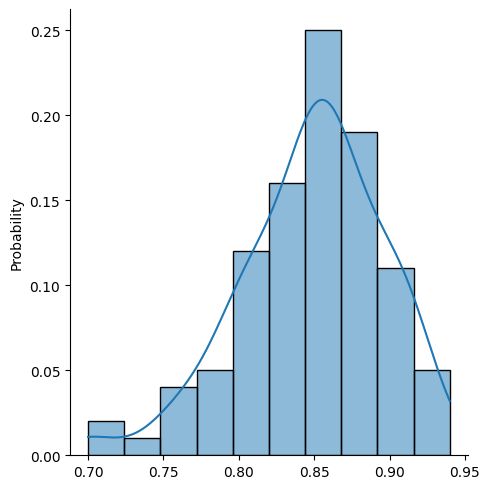

In [14]:
test_aucs.sort()
sns.displot(test_aucs, kde=True, stat='probability')
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower =  np.percentile(test_aucs, p)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper =  np.percentile(test_aucs, p)
print(f"mean AUC {np.mean(test_aucs)}") 
print(f"\n{alpha*100} confidence interval {lower} and {upper}")

test accuracy

mean accuracy 0.8146

95.0 confidence interval 0.74 and 0.8852499999999999


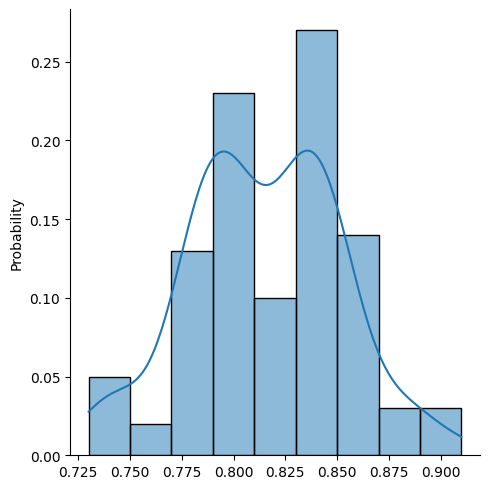

In [15]:
test_accurs.sort()
sns.displot(test_accurs, kde=True, stat='probability')
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower =  np.percentile(test_accurs, p)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper =  np.percentile(test_accurs, p)
print(f"mean accuracy {np.mean(test_accurs)}") 
print(f"\n{alpha*100} confidence interval {lower} and {upper}")

test recall

mean recall 0.7562999999999999

95.0 confidence interval 0.64475 and 0.85


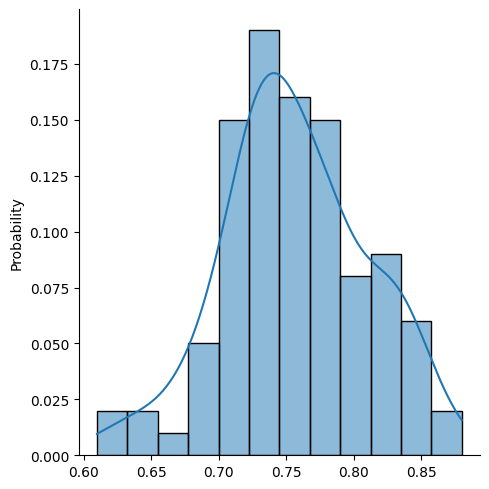

In [16]:
test_recalls.sort()
sns.displot(test_recalls, kde=True, stat='probability')
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower =  np.percentile(test_recalls, p)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper =  np.percentile(test_recalls, p)
print(f"mean recall {np.mean(test_recalls)}") 
print(f"\n{alpha*100} confidence interval {lower} and {upper}")

test precision

mean precision 0.7547

95.0 confidence interval 0.65 and 0.8452499999999998


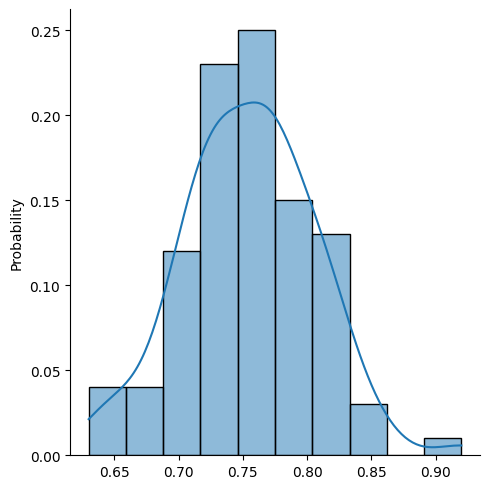

In [17]:
test_precisions.sort()
sns.displot(test_precisions, kde=True, stat='probability')
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower =  np.percentile(test_precisions, p)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper =  np.percentile(test_precisions, p)
print(f"mean precision {np.mean(test_precisions)}") 
print(f"\n{alpha*100} confidence interval {lower} and {upper}")

test F1 score

mean F1 0.7525000000000002

95.0 confidence interval 0.65 and 0.84


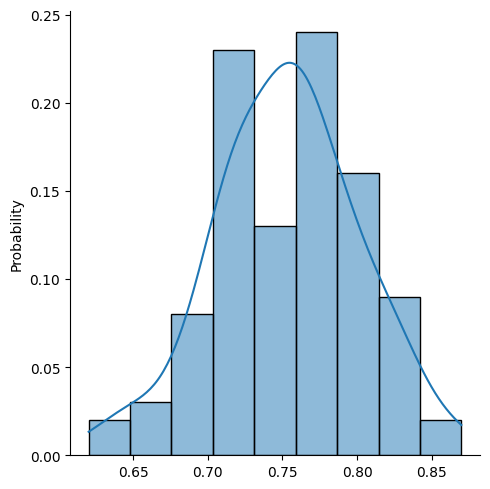

In [18]:
test_f1scores.sort()
sns.displot(test_f1scores, kde=True, stat='probability')
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower =  np.percentile(test_f1scores, p)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper =  np.percentile(test_f1scores, p)
print(f"mean F1 {np.mean(test_f1scores)}")   
print(f"\n{alpha*100} confidence interval {lower} and {upper}")

## save pipeline

In [19]:
mean_score = round(np.mean(test_aucs),2)
print("mean AUC",mean_score)
print("best AUC", np.max(test_aucs))
print("worst AUC", np.min(test_aucs))
# find random_state for split to save model
mean_randomstates = [df['random_state'][i] for i, v in enumerate(df['test_auc'].tolist())if v == mean_score] 
mean_randomstates

mean AUC 0.85
best AUC 0.94
worst AUC 0.7


[4, 16, 18, 27, 38, 40, 50, 61, 64, 77, 80, 87, 94]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=mean_randomstates[0], stratify=y)
M6W_voting_cal_allfeat_pipeline.fit(X_train,y_train)
y_hat = M6W_voting_cal_allfeat_pipeline.predict(X_test)
y_prob = M6W_voting_cal_allfeat_pipeline.predict_proba(X_test)
print(roc_auc_score(y_test, y_prob[:,1]))
print(classification_report(y_test, y_hat))
joblib.dump(M6W_voting_cal_allfeat_pipeline, "../results/M_6weeks/ENS/M_6weeks_ENS_model_allfeatures_calibrated.pkl")

0.851639344262295
              precision    recall  f1-score   support

           0       0.85      0.84      0.84        61
           1       0.52      0.55      0.54        20

    accuracy                           0.77        81
   macro avg       0.69      0.69      0.69        81
weighted avg       0.77      0.77      0.77        81



['../results/M_6weeks/ENS/M_6weeks_ENS_model_allfeatures_calibrated.pkl']